In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Single(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000)

        rnn_out, _ = self.rnn(V.unsqueeze(2)) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 30
device = torch.device("cuda")

epoch_no = 600
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy")
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/V_na_true_nona_pred.npy")
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU_Single(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3001


In [6]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V)
    loss = torch.mean((S_out - batch_S)**2)
    #loss = torch.var(S_out - batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        train_loss = explained_variance_score(batch_S.cpu().detach().numpy().flatten(), S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, train_loss)

<ipython-input-6-d90916cc9010>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/29400 [00:00<?, ?it/s]

0 0.003654956817626953 0.00276261568069458
49 0.015817701816558838 0.01420891284942627
99 0.022931039333343506 0.020646393299102783
149 0.030654191970825195 0.03240633010864258
199 0.04324197769165039 0.04176795482635498
249 0.0788457989692688 0.0690653920173645
299 0.09913980960845947 0.09093284606933594
349 0.14000064134597778 0.13916456699371338
399 0.15656137466430664 0.11660075187683105
449 0.16989076137542725 0.16999882459640503
499 0.1930309534072876 0.20378154516220093
549 0.19522559642791748 0.20055216550827026
599 0.2210807204246521 0.1833783984184265
649 0.21837884187698364 0.20419460535049438
699 0.20536810159683228 0.19601833820343018
749 0.2298659086227417 0.22992593050003052
799 0.08165299892425537 0.11221921443939209
849 0.19363760948181152 0.1933801770210266
899 0.23411494493484497 0.24361956119537354
949 0.19289636611938477 0.20680618286132812
999 0.2458750605583191 0.28125452995300293
1049 0.1157878041267395 0.12971407175064087
1099 0.2576748728752136 0.2426970601081

9399 0.4169386625289917 0.5038189888000488
9449 0.41970276832580566 0.4746127724647522
9499 0.37634772062301636 0.40677398443222046
9549 0.41659319400787354 0.3519209623336792
9599 0.41914182901382446 0.41402721405029297
9649 0.4146210551261902 0.42800062894821167
9699 0.40331876277923584 0.29817885160446167
9749 0.4203034043312073 0.5490283966064453
9799 0.40795809030532837 0.41062307357788086
9849 0.410918653011322 0.4197313189506531
9899 0.4012886881828308 0.35123950242996216
9949 0.4178733229637146 0.4681527614593506
9999 0.426597535610199 0.4010968804359436
10049 0.4196183681488037 0.38846641778945923
10099 0.4053289294242859 0.4831223487854004
10149 0.41187751293182373 0.5146622657775879
10199 0.4210841655731201 0.3937288522720337
10249 0.41271865367889404 0.43657100200653076
10299 0.39193713665008545 0.4071289896965027
10349 0.421860933303833 0.4425956606864929
10399 0.42004263401031494 0.48847639560699463
10449 0.41469675302505493 0.4025077223777771
10499 0.4052771329879761 0.4

18599 0.44412803649902344 0.4584802985191345
18649 0.43287360668182373 0.5080105066299438
18699 0.43830955028533936 0.44283467531204224
18749 0.44696831703186035 0.4627460837364197
18799 0.4022687077522278 0.5122913718223572
18849 0.43816077709198 0.4107903838157654
18899 0.4463462829589844 0.4147285223007202
18949 0.43439674377441406 0.5120245218276978
18999 0.426341712474823 0.44110363721847534
19049 0.40420985221862793 0.49329084157943726
19099 0.4409651756286621 0.49788612127304077
19149 0.4459106922149658 0.468772292137146
19199 0.43096041679382324 0.4757150411605835
19249 0.4317691922187805 0.5589313507080078
19299 0.4383344054222107 0.4495469331741333
19349 0.42149150371551514 0.4451531767845154
19399 0.4314163327217102 0.5773462057113647
19449 0.43842822313308716 0.6000167727470398
19499 0.42394375801086426 0.48717647790908813
19549 0.4159742593765259 0.39620792865753174
19599 0.4354742765426636 0.4469081163406372
19649 0.4437105059623718 0.4492707848548889
19699 0.426185369491

27799 0.45385217666625977 0.4162742495536804
27849 0.45203036069869995 0.3673814535140991
27899 0.4220468997955322 0.45457541942596436
27949 0.4509209394454956 0.49241405725479126
27999 0.45143574476242065 0.4883255362510681
28049 0.4420057535171509 0.47645944356918335
28099 0.4527933597564697 0.4876217246055603
28149 0.44542717933654785 0.49060821533203125
28199 0.4423578381538391 0.4789251685142517
28249 0.42410576343536377 0.49843788146972656
28299 0.4380427598953247 0.4555248022079468
28349 0.44626814126968384 0.4324690103530884
28399 0.4330447316169739 0.52403324842453
28449 0.4597820043563843 0.4601871371269226
28499 0.42631280422210693 0.4202759861946106
28549 0.44584202766418457 0.5329813957214355
28599 0.45618921518325806 0.4655805826187134
28649 0.44051897525787354 0.4777097702026367
28699 0.44354379177093506 0.45961904525756836
28749 0.44369232654571533 0.38618898391723633
28799 0.4528582692146301 0.5193308591842651
28849 0.43897008895874023 0.4413912296295166
28899 0.435965

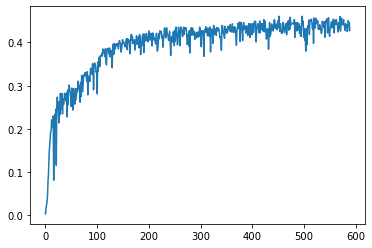

In [7]:
plt.plot(np.asarray(score_list))

(23000.0, 26000.0)

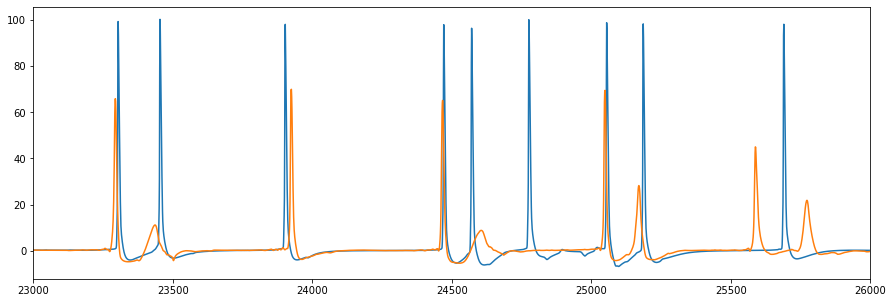

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/gru_h30.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/gru_h30_test.npy", test_S_out.cpu().detach().numpy())